In [33]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem

In [43]:
fn='NIST/openasr20_amharic/dev/audio/BABEL_OP3_307_60498_20140823_192847_outLine.wav'

In [45]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'amharic', 'dev') 

In [46]:
import soundfile as sf
import pyAudioAnalysis.audioSegmentation as aS
from normalize import normalize
from split_on_silence import split_on_silence

In [47]:
(audio,Fs) = sf.read(fn)
audio = normalize(audio)

In [86]:
(st_win, st_step) = 0.05, 0.05
smoothWindow = 1
weight = 0.5
segments = aS.silence_removal(audio, Fs, st_win, st_step, smoothWindow, weight)
min_length=0.185
regions=[(int(C.sample_rate*x), int(C.sample_rate*y)) for x,y in segments] # if y-x >= min_length]

[(y-x)/16000 for x,y in regions]

[0.75,
 2.35,
 0.75,
 1.4,
 1.9,
 5.55,
 2.65,
 0.6,
 1.0,
 1.7,
 0.25,
 2.05,
 3.1,
 2.25,
 2.55,
 0.2,
 1.35,
 1.35,
 0.8,
 1.05,
 1.45,
 0.95,
 1.35,
 4.4,
 5.15,
 6.15,
 0.4,
 3.1,
 4.1,
 1.2,
 1.65,
 2.7,
 12.65,
 5.7,
 0.95,
 1.55,
 0.55,
 0.55,
 2.75,
 5.5,
 4.9,
 8.75,
 4.8,
 3.55,
 5.25,
 3.1,
 0.2,
 5.8,
 3.35,
 7.05,
 7.05,
 5.8,
 2.6,
 21.65,
 5.25,
 4.6,
 4.8,
 12.1,
 2.5,
 1.4,
 11.8,
 28.1,
 1.3,
 2.7,
 9.75,
 49.25,
 29.6,
 5.05,
 0.75,
 0.45,
 0.75,
 1.85,
 0.85,
 6.0,
 20.35]

In [59]:
too_short = 0.2
for start, end in regions:
    goal_length_in_seconds = 16.5
    seconds = (end-start)/C.sample_rate
    if seconds > goal_length_in_seconds:
        break

In [78]:
clip = audio[start:end]
t_lower=0.3
t_upper=0.8
Window = 500
min_gap = 10
A=split_on_silence(audio, t_lower, t_upper, Window, min_gap, C.sample_rate, 16.5)

In [79]:
len(A)

53

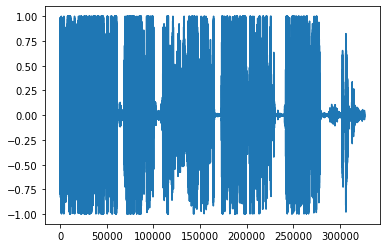

In [62]:
%matplotlib inline
import matplotlib.pylab as plt
plt.plot(clip)

## Check clip sizes

In [87]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'amharic', 'dev') 

In [88]:
splits=C.split_files()

In [89]:
L=[x['t_seconds'] for x in splits]

In [93]:
min(L),max(L),sum(L)/len(L)

(0.2, 16.4, 2.503844414292162)

In [90]:
[x for x in splits if x['t_seconds']>16.5]

[]

## Add vocoder clips to training set

## Train step 1: Bootstrap from pretrained model

In [ ]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'amharic', 'build') 

In [ ]:
from load_pretrained_amharic_model import load_pretrained_amharic_model
model = load_pretrained_amharic_model(C, 0)

In [ ]:
import pytorch_lightning as pl
import os, datetime

model_save_dir='save/nemo_amharic'

class ModelCheckpointAtEpochEnd(pl.callbacks.ModelCheckpoint):
    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        metrics['epoch'] = trainer.current_epoch
        trainer.checkpoint_callback.on_validation_end(trainer, pl_module)

pid=os.getpid()
dt=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

checkpoint_callback = ModelCheckpointAtEpochEnd(
    filepath=model_save_dir+'/amharic_'+f'{dt}_{pid}'+'_{epoch:02d}',
    verbose=True,
    save_top_k=-1,
    save_weights_only=False,
    period=1)

trainer = pl.Trainer(gpus=[0], max_epochs=200, amp_level='O1', precision=16, checkpoint_callback=checkpoint_callback)

In [ ]:
from ruamel.yaml import YAML
from omegaconf import DictConfig
config_path = 'amharic_16000.yaml'
yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
train_manifest=f'{C.build_dir}/train_manifest.json'
test_manifest=f'{C.build_dir}/test_manifest.json'
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
model.set_trainer(trainer)
model.setup_training_data(train_data_config=params['model']['train_ds'])
model.setup_validation_data(val_data_config=params['model']['validation_ds'])
model.setup_optimization(optim_config=DictConfig(params['model']['optim']))

In [ ]:
from reshuffle_samples import reshuffle_samples
reshuffle_samples(C)

In [ ]:
trainer.fit(model)

## Apply vocoder filter to DEV

## DEV translation

In [ ]:
from Cfg import Cfg
from glob import glob
from package_DEV import package_DEV
from load_pretrained_amharic_model import load_pretrained_amharic_model
version='113'
C = Cfg('NIST', 16000, 'amharic', 'dev', version)
model = load_pretrained_amharic_model(C, 0)
files=list(sorted(glob(f'{C.audio_split_dir}/*.wav')))
translations=model.transcribe(paths2audio_files=files, batch_size=32)
